## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import os
import pickle
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from glob import glob

%matplotlib inline


# Camera calibration using chessboard images 

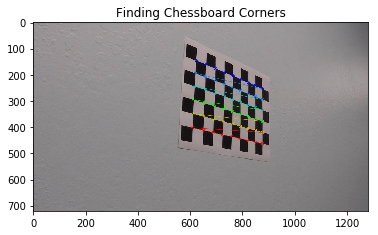

In [2]:
# Known Object Coordinates of the chessboard 
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

calibration_images = 'camera_cal/calibration*.jpg'

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob(calibration_images)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # glob used to read images

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.title('Finding Chessboard Corners')
        plt.imshow(img)
  


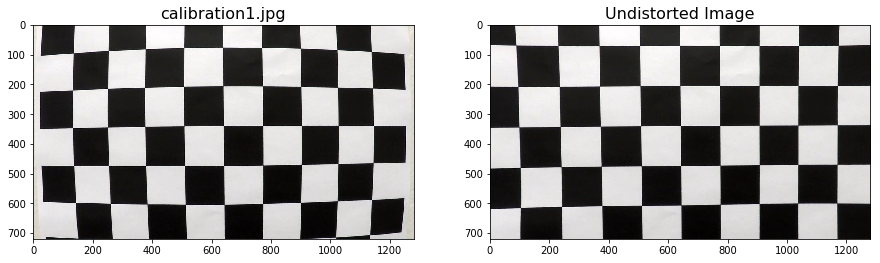

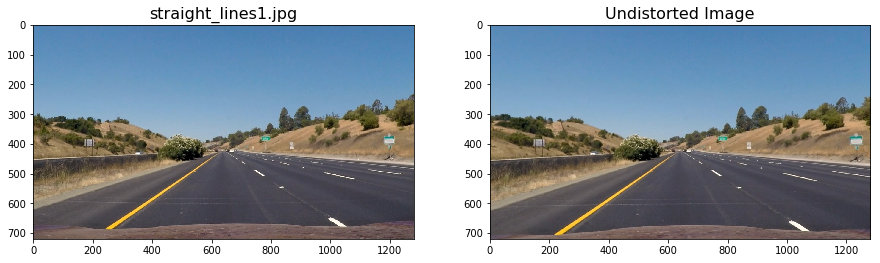

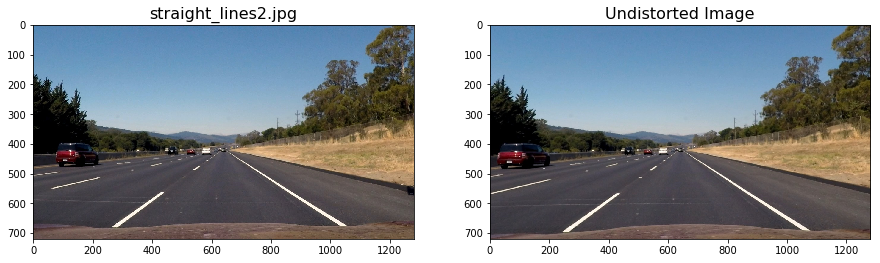

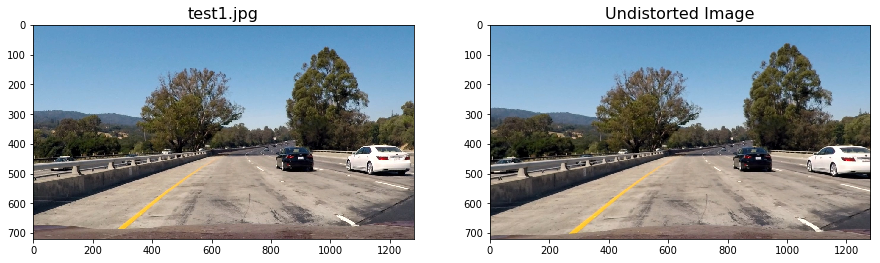

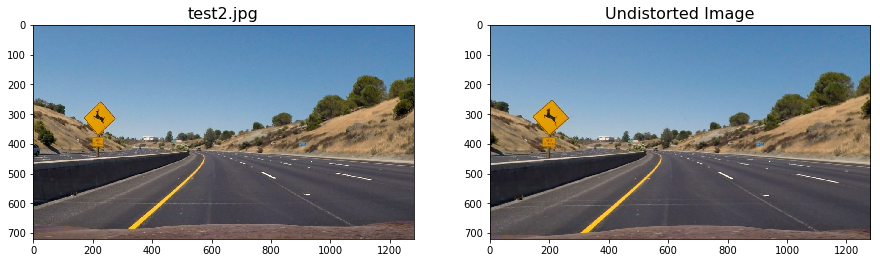

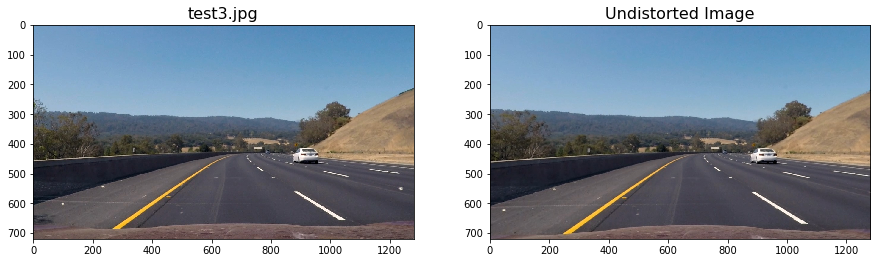

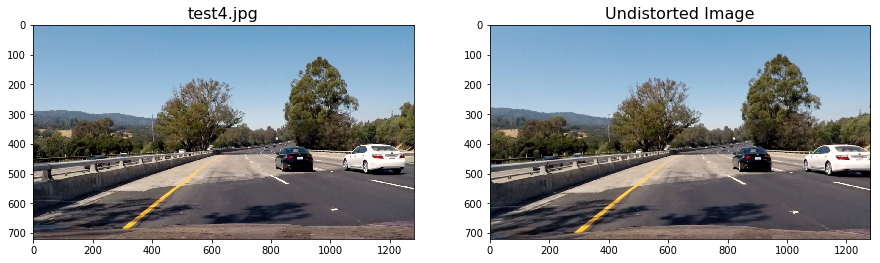

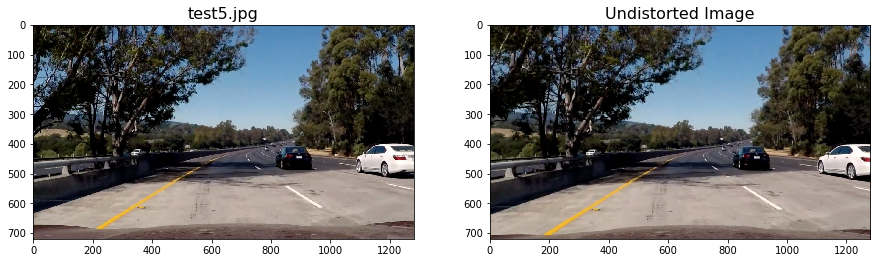

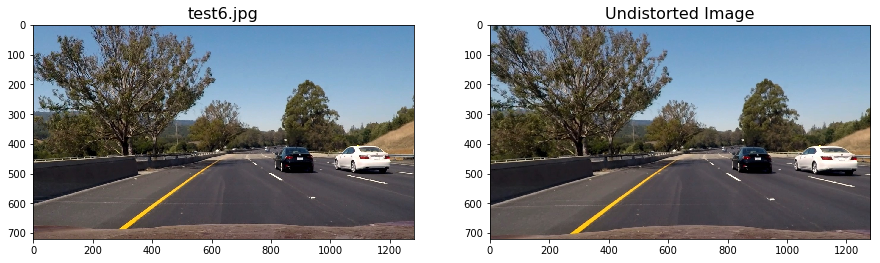

In [44]:
chess_distortion_correction_folder = 'output_images/1.camera_cal_Output'
if not os.path.exists(chess_distortion_correction_folder):
    os.makedirs(chess_distortion_correction_folder)
def undistort(img):
    image_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

test_images = 'test_images/*.jpg'    
test_images_list = glob(test_images)
album=os.listdir("test_images/")
for image, photo in zip(test_images_list, album):
    img = cv2.imread(image)
    f, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,10))
    axis1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axis1.set_title(photo, fontsize=16)
    axis2.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
    axis2.set_title('Undistorted Image', fontsize=16)    
    plt.savefig(chess_distortion_correction_folder+"/"+photo)

# Warping and Color filter



In [46]:
filtered_birds_eye_view_imgs_folder = 'output_images/2.filtered_birds_eye_view_Output'
if not os.path.exists(filtered_birds_eye_view_imgs_folder):
    os.makedirs(filtered_birds_eye_view_imgs_folder)
# Do perspective transform
def birds_eye_view(image):
    # image=cv2.imread(image)
    image_size = (image.shape[1], image.shape[0])
    offset = 0
    source = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    destination = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(source, destination)
    warped = cv2.warpPerspective(image, M, image_size)
    return warped

In [47]:
# Do reverse perspective transform
def normal_view(image):
    # image=cv2.imread(image)
    image_size = (image.shape[1], image.shape[0])
    offset = 0
    destination = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    source = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(source, destination)
    unwarped = cv2.warpPerspective(image, M, image_size)
    return unwarped

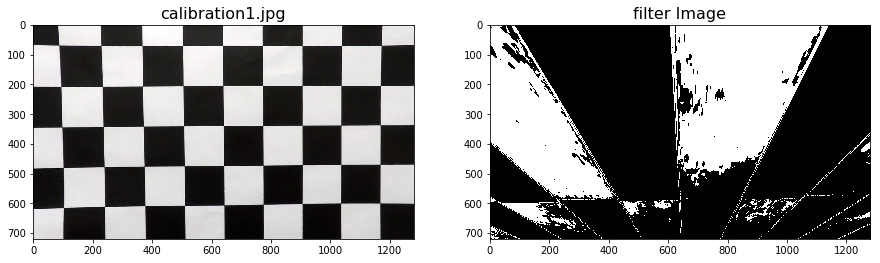

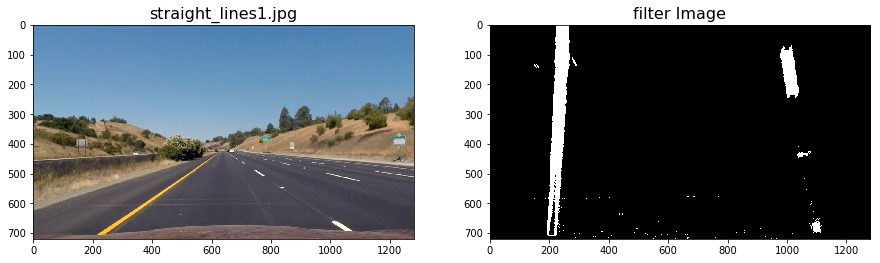

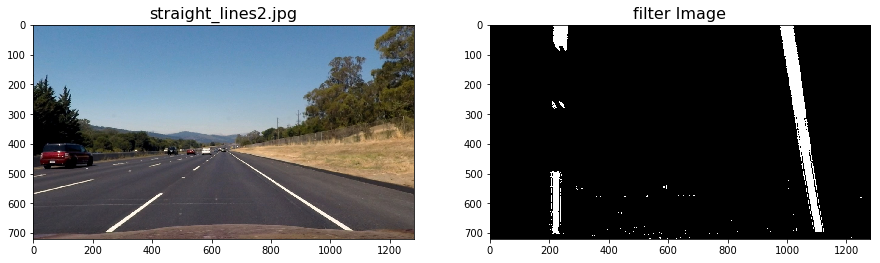

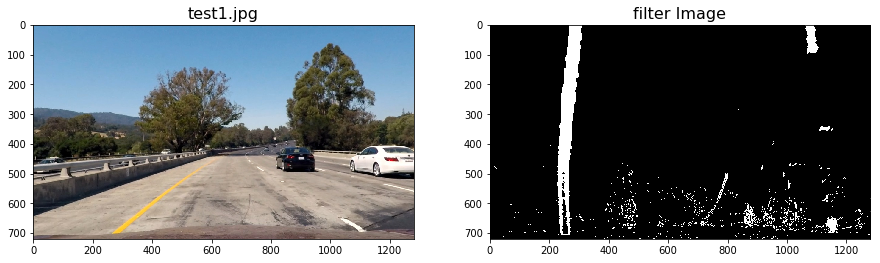

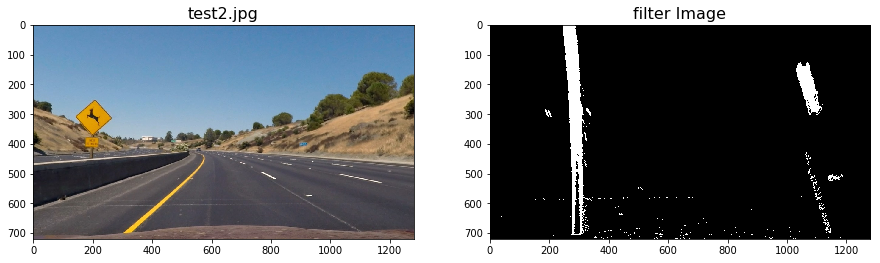

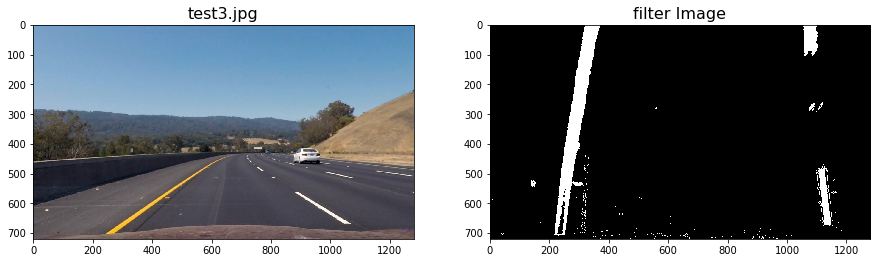

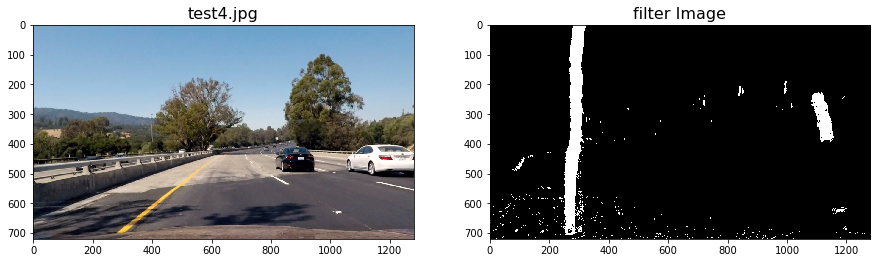

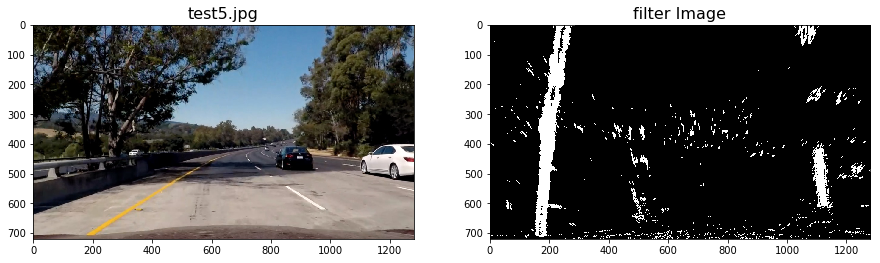

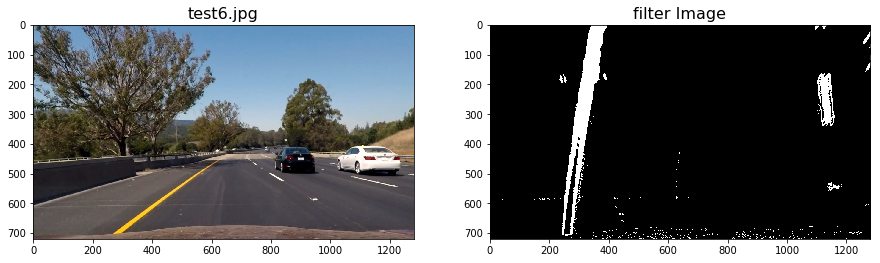

In [48]:
def color_filter(image):
    s_channel_of_hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,2]
    l_channel_of_luv = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel_of_bgr = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Defining threshold of the color channels used
    s_threshold_min = 180
    s_threshold_max = 255
    s_binary = np.zeros_like(s_channel_of_hls)
    s_binary[(s_channel_of_hls >= s_threshold_min) & (s_channel_of_hls <= s_threshold_max)] = 1
    
    l_threshold_min = 225
    l_threshold_max = 255
    l_binary = np.zeros_like(l_channel_of_luv)
    l_binary[(l_channel_of_luv >= l_threshold_min) & (l_channel_of_luv <= l_threshold_max)] = 1

    b_threshold_min = 155
    b_threshold_max = 200
    b_binary = np.zeros_like(b_channel_of_bgr)
    b_binary[(b_channel_of_bgr >= b_threshold_min) & (b_channel_of_bgr <= b_threshold_max)] = 1
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

test_images = 'test_images/*.jpg'    
test_images_list = glob(test_images)
album=os.listdir("test_images/")
for i, image, photo in zip(range(len(test_images_list)), test_images_list, album):
    img = undistort(cv2.imread(image))
    f, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,10))
    axis1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axis1.set_title(photo, fontsize=16)
    wraped = birds_eye_view(img)
    filter=color_filter(wraped)
    axis2.imshow(filter, cmap='gray')
    axis2.set_title('filter Image', fontsize=16)
    plt.savefig(filtered_birds_eye_view_imgs_folder+"/"+photo)

# Sliding window search technique

Finding the lane pixels in the warped binary, showing even better results.

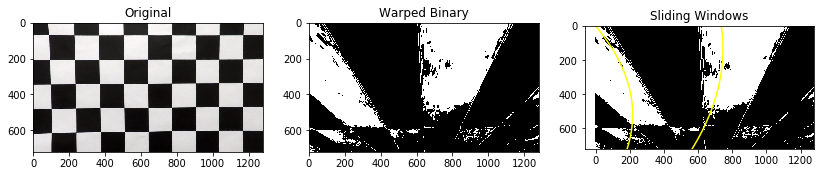

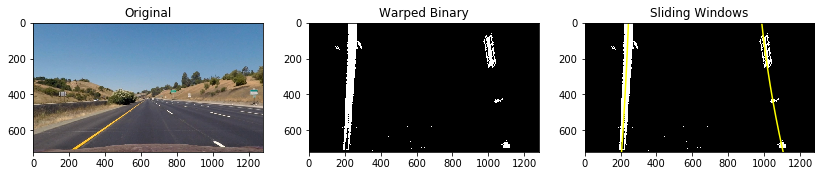

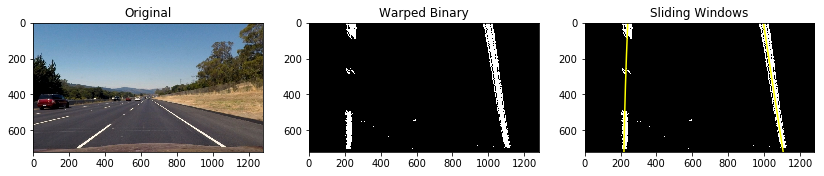

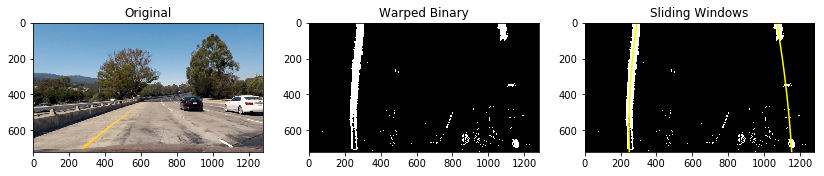

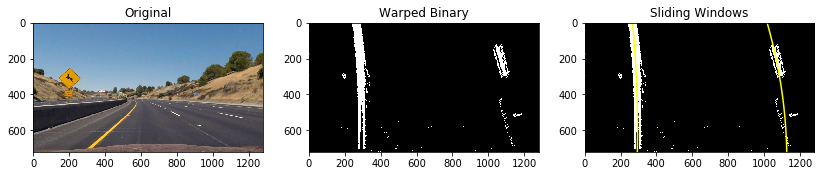

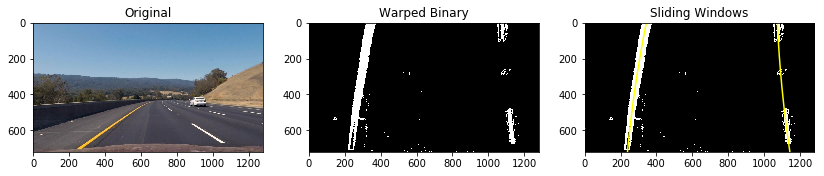

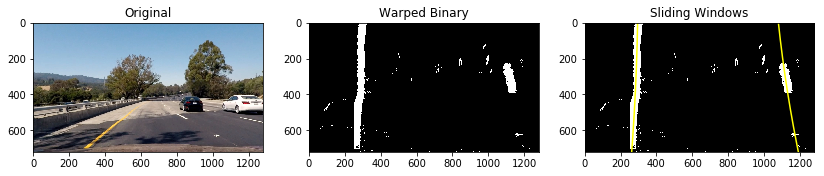

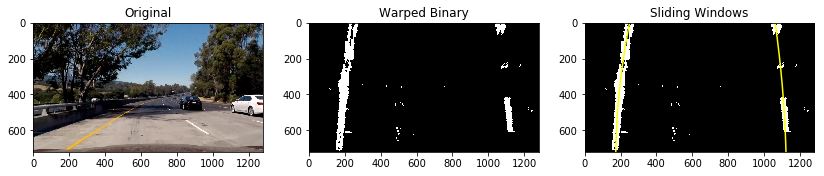

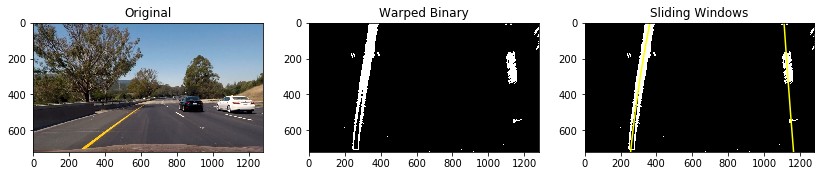

In [49]:
def sliding_search(binary_warped, plot=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[360:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    else:
        left_fit = None
        left_fitx = None

    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        right_fix = None
        right_fitx = None

    if plot:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        return left_fitx, right_fitx, ploty, out_img
    return left_fitx, right_fitx, ploty


for imgpath in glob('./test_images/*.jpg'):
    img = undistort(cv2.imread(imgpath))
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(14)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original')
    filtered = color_filter(img)
    warped = birds_eye_view(filtered)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('Warped Binary')
    lfx, rfx, ploty, lanes = sliding_search(warped, plot=True)
    ax3.imshow(lanes, cmap='gray')
    ax3.plot(lfx, ploty, color='yellow')
    ax3.plot(rfx, ploty, color='yellow')
    ax3.set_title('Sliding Windows')
    plt.show()
    

# Curvature and Drawing



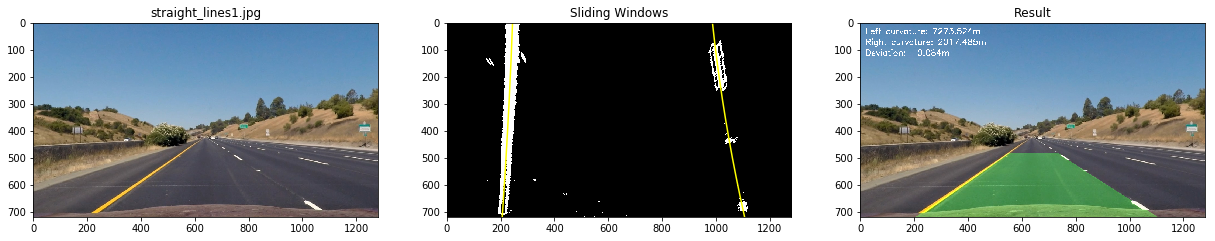

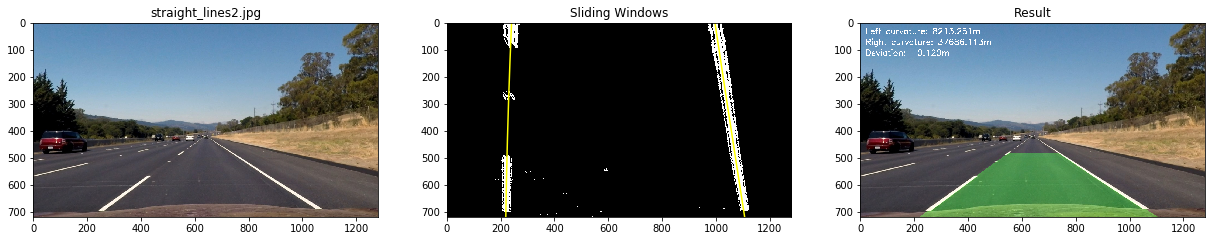

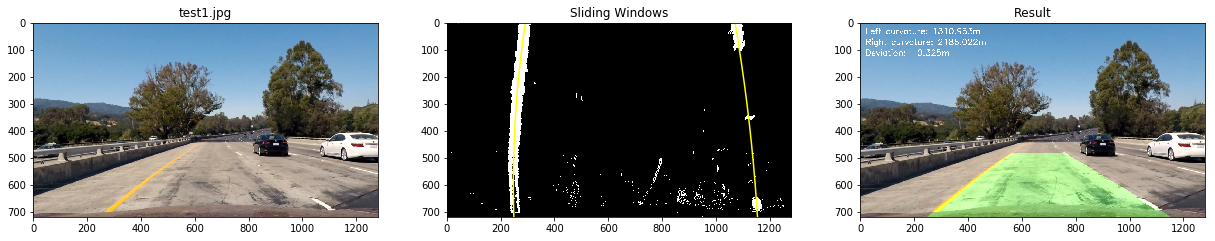

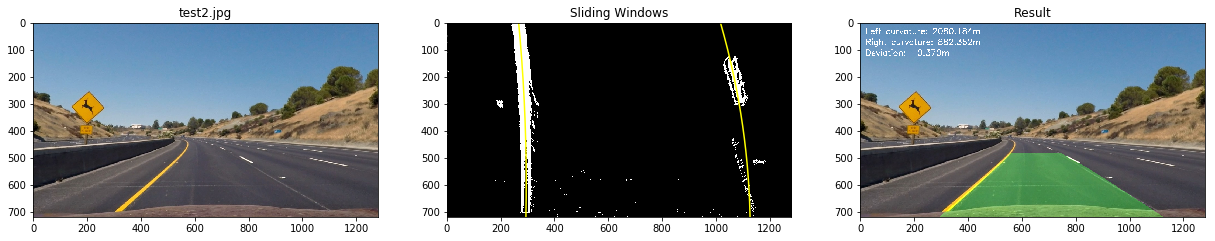

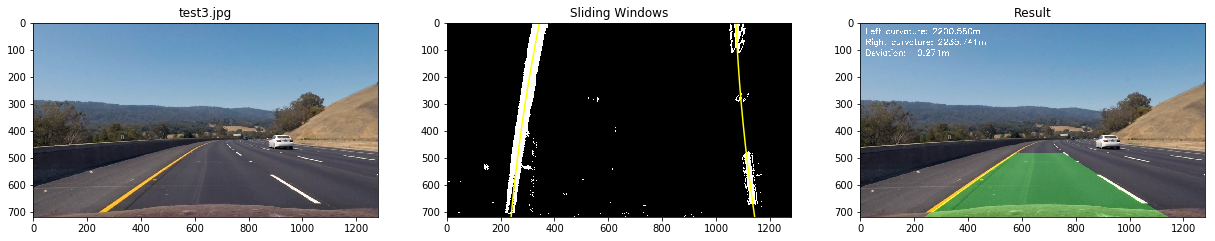

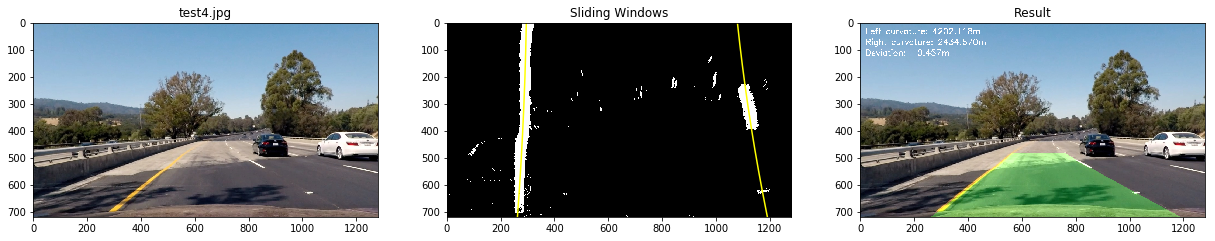

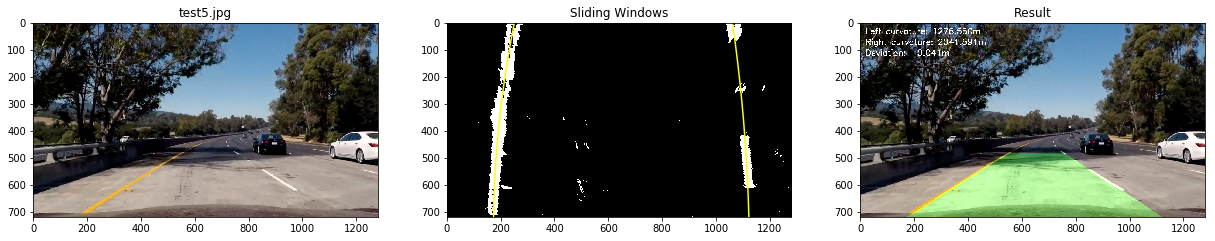

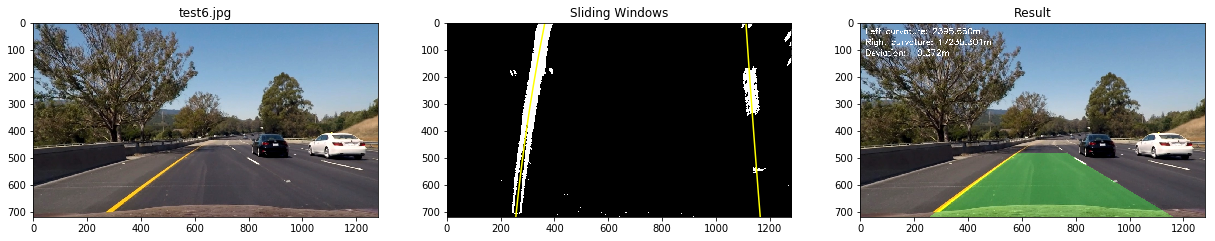

In [51]:
color_lanes_imgs_folder = 'output_images/3.color_lanes_Output'
if not os.path.exists(color_lanes_imgs_folder):
    os.makedirs(color_lanes_imgs_folder)
def calculate_curvature_deviation(left_fitx, right_fitx, ploty):
    x_mpp = 3.7/700  # 3.7m per 700 pixels, estimated from warped binaries
    y_mpp = 30.0/720 # 30m for the whole height of the warped binary
    lane_center = (left_fitx[-1] + right_fitx[-1]) / 2 # Lane center in pixels
    deviation = (1280 / 2 - lane_center) * x_mpp # Deviation from center converted to meters
    
    left_fitxm = np.polyfit(ploty * y_mpp, left_fitx * x_mpp, 2)
    right_fitxm = np.polyfit(ploty * y_mpp, right_fitx * x_mpp, 2)
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fitxm[0]*y_eval*y_mpp + left_fitxm[1])**2)**1.5) / np.absolute(2*left_fitxm[0])
    right_curverad = ((1 + (2*right_fitxm[0]*y_eval*y_mpp + right_fitxm[1])**2)**1.5) / np.absolute(2*right_fitxm[0])
    return left_curverad, right_curverad, deviation

def draw_lanes(undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

def plot_back(undist, left_fitx, right_fitx, ploty):
    color_warp = draw_lanes(undist, left_fitx, right_fitx, ploty)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = normal_view(color_warp)
    # Combine the result with the original image
    output = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Annotate curvature and deviation
    left_curve, right_curve, deviation = calculate_curvature_deviation(left_fitx, right_fitx, ploty)
    cv2.putText(output, 'Left curvature: {:.3f}m'.format(left_curve), (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(output, 'Right curvature: {:.3f}m'.format(right_curve), (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(output, 'Deviation: {:.3f}m'.format(deviation), (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    return output

album=os.listdir("test_images/")
for imgpath, photo in zip(glob('./test_images/*.jpg'), album):
    img = undistort(cv2.imread(imgpath))
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(21)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title(photo)
    filtered = color_filter(img)
    warped = birds_eye_view(filtered)
    lfx, rfx, ploty, lanes = sliding_search(warped, plot=True)
    ax2.imshow(lanes, cmap='gray')
    ax2.plot(lfx, ploty, color='yellow')
    ax2.plot(rfx, ploty, color='yellow')
    ax2.set_title('Sliding Windows')
    ax3.imshow(cv2.cvtColor(plot_back(img, lfx, rfx, ploty), cv2.COLOR_BGR2RGB))
    ax3.set_title('Result')
    plt.savefig(color_lanes_imgs_folder+"/"+photo)

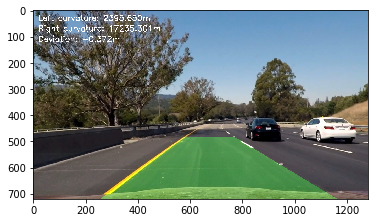

In [53]:
plt.imshow(cv2.cvtColor(plot_back(img, lfx, rfx, ploty), cv2.COLOR_BGR2RGB))

# Pipeline


In [43]:
alpha = 0.25
max_diff = 50

avg_lfx, avg_rfx, ploty = None, None, ploty
skip_frame = False

def process_frame_avg(img):
    global skip_frame
    img = undistort(img)
    if not skip_frame:
        global avg_lfx
        global avg_rfx
        global ploty
        filtered = color_filter(img)
        warped = birds_eye_view(filtered)
        lfx, rfx, ploty = sliding_search(warped)
        if avg_lfx is None:
            avg_lfx = lfx
        if avg_rfx is None:
            avg_rfx = rfx

        if lfx is not None:
            diff = np.average(np.abs(avg_lfx - lfx))
            cv2.putText(img, 'Left diff: {:.2f}'.format(diff), (500, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            if diff < max_diff: # Drop and using previous diff to estimate position
                avg_lfx = alpha * lfx + (1 - alpha) * avg_lfx
        if rfx is not None:
            diff = np.average(np.abs(avg_rfx - rfx))
            cv2.putText(img, 'Right diff: {:.2f}'.format(diff), (500, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            if diff < max_diff:
                avg_rfx = alpha * rfx + (1 - alpha) * avg_rfx

    skip_frame = not skip_frame
    return plot_back(img, avg_lfx, avg_rfx, ploty)

input_video = 'project_video.mp4'
output_video = 'output_{}'.format(input_video)

clip = VideoFileClip(input_video)
clip.fl_image(process_frame_avg).write_videofile(output_video, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [18:28<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

